# Data Prepration for GoodReads Dataset
## (Efficient) Loading, Cleaning, Preprocessing

### Setup

In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display


Dataset directory

In [2]:
DIR = './data'

#### Load Data
using pandas to read the JSON data - ~using already unzipped JSON file to improve performance~ and to later make the switch to DASK.

**only using 30k rows of books and 30k reviews**

In [3]:
in_fn_books = 'goodreads_books_mystery_thriller_crime.json.gz'
in_fn_reviews = 'goodreads_reviews_mystery_thriller_crime.json.gz'
in_fn_authors = 'goodreads_book_authors.json'

In [32]:
df_books = pd.read_json(os.path.join(DIR, in_fn_books), lines=True, nrows=30000,dtype={
    "title": 'string', 
    "description": 'string', 
    "text_reviews_count": 'uint', 
    'average_rating': 'float'
})

In [33]:
df_reviews = pd.read_json(os.path.join(DIR, in_fn_reviews), lines=True, nrows=30000, 
dtype = {
'book_id': 'uint32',
'rating': 'uint8',
'review_text': 'string',
})

# set the datatypes to save memory already when reading

In [9]:
df_authors = pd.read_json(os.path.join(DIR, in_fn_authors), lines=True, nrows=30000,
dtype = {
    'author': 'name'
})

#### Clean Data
remove unnecessary columns, set index

In [34]:
df_books.set_index("book_id", inplace=True)
df_reviews.set_index("review_id", inplace=True)

In [11]:
df_reviews.drop(columns=['date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments'], inplace=True)

In [12]:
df_reviews.head(5)

,user_id,book_id,rating,review_text
review_id,,,,
5e212a62bced17b4dbe41150e5bb9037,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ..."
8e4d61801907e591018bdc3442a9cf2b,8842281e1d1347389f2ab93d60773d4d,32283133,0,http://www.telegraph.co.uk/culture/10...
022bb6daffa49adc27f6b20b6ebeb37d,8842281e1d1347389f2ab93d60773d4d,17860739,4,An amazing and unique creation: JJ Abrams and ...
0e317947e1fd341f573192111bb2921d,8842281e1d1347389f2ab93d60773d4d,8694005,3,The Name of the Rose is a thrilling Dan Brown-...


In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 5e212a62bced17b4dbe41150e5bb9037 to fe5d37c996018831a2a0f7ee013a0295
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      30000 non-null  object
 1   book_id      30000 non-null  uint32
 2   rating       30000 non-null  uint8 
 3   review_text  30000 non-null  object
dtypes: object(2), uint32(1), uint8(1)
memory usage: 849.6+ KB


In [14]:
df_books.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,isbn13,publication_month,edition_information,publication_year,url,image_url,ratings_count,work_id,title,title_without_series
book_id,,,,,,,,,,,,,,,,,,,,,
6066814,184737297X,15,[169353],US,,"[{'count': '159', 'name': 'to-read'}, {'count'...",,false,3.93,B007YLTG5I,...,9781847372970,4,,2009,https://www.goodreads.com/book/show/6066814-cr...,https://images.gr-assets.com/books/1328724803m...,186,6243149,"Crowner Royal (Crowner John Mystery, #13)","Crowner Royal (Crowner John Mystery, #13)"
33394837,,60,[1052227],US,eng,"[{'count': '54', 'name': 'currently-reading'},...",B01NCIKAQX,true,4.33,B01NCIKAQX,...,,,,,https://www.goodreads.com/book/show/33394837-t...,https://images.gr-assets.com/books/1493114742m...,269,54143148,The House of Memory (Pluto's Snitch #2),The House of Memory (Pluto's Snitch #2)
29074697,,23,[953679],US,eng,"[{'count': '90', 'name': 'to-read'}, {'count':...",B01ALOWJN0,true,3.49,B01ALOWJN0,...,,,,,https://www.goodreads.com/book/show/29074697-t...,https://s.gr-assets.com/assets/nophoto/book/11...,192,49305010,The Slaughtered Virgin of Zenopolis (Inspector...,The Slaughtered Virgin of Zenopolis (Inspector...
1902202,0854563903,8,[408775],US,,"[{'count': '51', 'name': 'to-read'}, {'count':...",,false,3.30,,...,9780854563906,12,Large Print,1975,https://www.goodreads.com/book/show/1902202.De...,https://s.gr-assets.com/assets/nophoto/book/11...,52,1903897,"Dead in the Morning (Patrick Grant, #1)","Dead in the Morning (Patrick Grant, #1)"
9671977,8838920931,3,[274410],US,ita,"[{'count': '48', 'name': 'to-read'}, {'count':...",,false,3.54,,...,9788838920936,,,2006,https://www.goodreads.com/book/show/9671977-ar...,https://images.gr-assets.com/books/1474788304m...,22,2152906,Aristotele e i misteri di Eleusi,Aristotele e i misteri di Eleusi


In [27]:
df_authors = df_authors[['author_id', 'name']]
df_authors.set_index('author_id', inplace=True)

In [28]:
df_authors.head()

,name
author_id,
604031,Ronald J. Fields
626222,Anita Diamant
10333,Barbara Hambly
9212,Jennifer Weiner
149918,Nigel Pennick


In [29]:
df_authors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 604031 to 240076
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    30000 non-null  object
dtypes: object(1)
memory usage: 468.8+ KB


In [35]:
df_books['author_id'] = df_books['authors'].apply(lambda row: row[0]['author_id']) # just select the first author_id of the list of authors
df_books['author_id'] = df_books['author_id'].astype('int64')

In [36]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 6066814 to 23960943
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  30000 non-null  object 
 1   text_reviews_count    30000 non-null  uint32 
 2   series                30000 non-null  object 
 3   country_code          30000 non-null  object 
 4   language_code         30000 non-null  object 
 5   popular_shelves       30000 non-null  object 
 6   asin                  30000 non-null  object 
 7   is_ebook              30000 non-null  object 
 8   average_rating        30000 non-null  float64
 9   kindle_asin           30000 non-null  object 
 10  similar_books         30000 non-null  object 
 11  description           30000 non-null  object 
 12  format                30000 non-null  object 
 13  link                  30000 non-null  object 
 14  authors               30000 non-null  object 
 15  publisher 

In [19]:
c = df_books['country_code'].value_counts(dropna=False)

In [37]:
df_books = df_books[['title', 'text_reviews_count', 'popular_shelves', 'average_rating', 'description', 'author_id']]

In [41]:
df_books = df_books.join(df_authors, on='author_id')

In [42]:
display(df_books.head(5))
df_books.info()

,title,text_reviews_count,popular_shelves,average_rating,description,author_id,name
book_id,,,,,,,
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"[{'count': '159', 'name': 'to-read'}, {'count'...",3.93,"London, 1196. At the command of Richard the Li...",37778,Bernard Knight
33394837,The House of Memory (Pluto's Snitch #2),60,"[{'count': '54', 'name': 'currently-reading'},...",4.33,,242185,Carolyn Haines
29074697,The Slaughtered Virgin of Zenopolis (Inspector...,23,"[{'count': '90', 'name': 'to-read'}, {'count':...",3.49,"BATHS, BANKS AND ROMAN INSURRECTION\nDetective...",15104629,David Blake
1902202,"Dead in the Morning (Patrick Grant, #1)",8,"[{'count': '51', 'name': 'to-read'}, {'count':...",3.30,"Gerald breezily introduced his wife, Helen, to...",190988,Margaret Yorke
9671977,Aristotele e i misteri di Eleusi,3,"[{'count': '48', 'name': 'to-read'}, {'count':...",3.54,"""I misteri di Eleusi"" e il quinto romanzo di A...",337108,Margaret Doody


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 6066814 to 23960943
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               30000 non-null  object 
 1   text_reviews_count  30000 non-null  uint32 
 2   popular_shelves     30000 non-null  object 
 3   average_rating      30000 non-null  float64
 4   description         30000 non-null  object 
 5   author_id           30000 non-null  int64  
 6   name                16228 non-null  object 
dtypes: float64(1), int64(1), object(4), uint32(1)
memory usage: 1.7+ MB


### Save cleaned Dataset to use in next Notebook

In [43]:
OUT_DIR = 'data/cleaned/'

In [44]:
out_fn_books = in_fn_books.split('.')[0] + '.pkl'
out_fn_reviews = in_fn_reviews.split('.')[0] + '.pkl'
print(out_fn_books, out_fn_reviews)

goodreads_books_mystery_thriller_crime.pkl goodreads_reviews_mystery_thriller_crime.pkl


In [45]:
df_books.to_pickle(os.path.join(OUT_DIR, out_fn_books))

In [ ]:
df_reviews.to_pickle(os.path.join(OUT_DIR, out_fn_reviews))

---
unpickle

In [10]:
# df_reviews = pd.read_pickle(os.path.join(OUT_DIR, out_fn_reviews))
# df_books = pd.read_pickle(os.path.join(OUT_DIR, out_fn_books))

---
TODO:
- [ ] clean non-latin character entries (?)
- [ ] remove duplicates

----
## Backup for later use:
# Explode Popular Shelves
*Notice:* right now only using **mystery-thriller-crime** data!!

In [124]:
exp = df_books[:1000].explode('popular_shelves')
exp

,title,text_reviews_count,popular_shelves,average_rating
book_id,,,,
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"{'count': '159', 'name': 'to-read'}",3.93
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"{'count': '12', 'name': 'historical-fiction'}",3.93
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"{'count': '11', 'name': 'mystery'}",3.93
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"{'count': '10', 'name': 'historical-mystery'}",3.93
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,"{'count': '7', 'name': 'medieval'}",3.93
...,...,...,...,...
1122023,The Harrowing,196,"{'count': '1', 'name': '21st-century'}",3.68
1122023,The Harrowing,196,"{'count': '1', 'name': 'tbr-next'}",3.68
1122023,The Harrowing,196,"{'count': '1', 'name': 'to-be-bought'}",3.68


In [125]:
exp2 = pd.concat([exp, exp['popular_shelves'].apply(pd.Series)], axis = 1).drop('popular_shelves', axis = 1)
exp3 = exp2.astype({'count': 'uint', 'name': 'string'})
exp3

,title,text_reviews_count,average_rating,count,name
book_id,,,,,
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,159,to-read
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,12,historical-fiction
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,11,mystery
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,10,historical-mystery
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,7,medieval
...,...,...,...,...,...
1122023,The Harrowing,196,3.68,1,21st-century
1122023,The Harrowing,196,3.68,1,tbr-next
1122023,The Harrowing,196,3.68,1,to-be-bought


In [126]:
exp3.dtypes

title                  string
text_reviews_count     uint32
average_rating        float64
count                  uint32
name                   string
dtype: object

Conversion into sparse 2D matrix of appearances in all the different shelves
- if using this, maybe shelves should be consolidated into most popular ones

In [130]:
pivot2 = pd.pivot_table(exp3, columns='name', values='count', index=['book_id', 'title'])
pivot2

,name,-,--1-,--109-,--112-,--135-,--147-,--15-,--17-,--190-,--201-,...,小說,小說-懸疑推理,小説,悬疑推理,懸疑,日本文学,日本語,漫画-wishlist,特價精裝小說區,短篇集
book_id,title,,,,,,,,,,,,,,,,,,,,,
11532,Night Visions 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13143,"Pop Goes the Weasel (Alex Cross, #5)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13146,Black Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15672,The Strangers in the House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15676,Strangers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35920871,"Ashes Of Berlin, The (Gregor Reinhardt 3)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35957233,Tokyo Black (Thomas Caine #1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35994818,De museummoorden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
pivot = exp3.pivot(columns='name', values='count')
pivot

ValueError: Index contains duplicate entries, cannot reshape

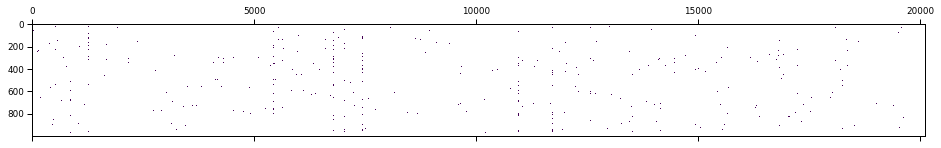

In [132]:
from matplotlib import pyplot as plt
plt.matshow(pivot2,aspect='auto')

let's find the most popular shelves

In [133]:
# pivot["0-owned"].unique()
s = pivot2.sum()
# sns.distplot
# p = s.sort_values(ascending=False).index[:20]
#pivot[p]

In [145]:
# del cleaned_s

In [146]:
cleaned_s = s.drop(['to-read', 'currently-reading', 'books-i-own', 'default', 'owned', 'owned-books', 'to-buy'])
#join similar categories
cleaned_s['mystery_'] = cleaned_s['mystery'] + cleaned_s['mysteries']
cleaned_s.drop(['mysteries', 'mystery'], inplace=True)
cleaned_s['thriller_'] = cleaned_s['thriller'] + cleaned_s['thrillers']
cleaned_s.drop(['thriller', 'thrillers'], inplace=True)

cleaned_s['audiobooks_'] = cleaned_s['audiobook'] + cleaned_s['audiobooks'] + cleaned_s['audio']
cleaned_s.drop(['audiobook', 'audiobooks', 'audio'], inplace=True)

cleaned_s['ebooks_kindle'] = cleaned_s['ebook'] + cleaned_s['ebooks'] + cleaned_s['kindle']
cleaned_s.drop(['ebook', 'ebooks', 'kindle'], inplace=True)

cleaned_s.sort_values(ascending=False, inplace=True)


<AxesSubplot:ylabel='name'>

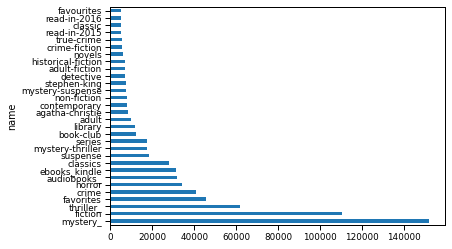

In [147]:
cleaned_s.head(30).plot(kind='barh')

In [148]:
cleaned_s.head(4)

name
mystery_     151851.0
fiction      110217.0
thriller_     61739.0
favorites     45621.0
dtype: float64

<AxesSubplot:ylabel='name'>

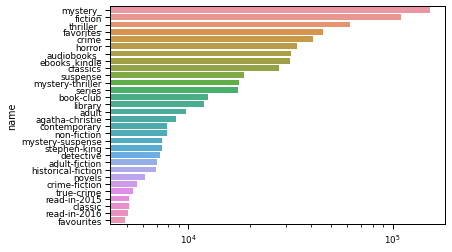

In [151]:
sns.barplot(cleaned_s.head(30).values, cleaned_s.head(30).index, log=True)